In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)


In [2]:
def get_ensemble(models, input_shape, weights=None):
    x = tf.keras.layers.Input(shape=input_shape)
    if weights is None:
        weights = [np.ones((1, 5)) / len(models) for _ in range(len(models))]

    y = [model(x) * w for model, w in zip(models, weights)]
    y = tf.reduce_sum(y, axis=0)
    model = tf.keras.Model(inputs=x, outputs=y)
    return model


def get_data():

    noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        dtype=np.float32
    )

    train_generator = noaug_datagen.flow_from_directory(
        "/kaggle/input/knee-dataset2/data_set/train",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    valid_generator = noaug_datagen.flow_from_directory(
        "/kaggle/input/knee-dataset2/data_set/val",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    test_generator = noaug_datagen.flow_from_directory(
        "/kaggle/input/knee-dataset2/data_set/test",
        class_mode="categorical",
        target_size=(224, 224),
        shuffle=False,
    )

    return train_generator, valid_generator, test_generator


def get_metrics(model, data, name=None, show_results=True):
    if name is None:
        name = model.name

    y_true = data.labels
    y_pred = np.argmax(model.predict(data), axis=1)

    acc = accuracy_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    accuracies = np.diag(cm)

    for i, a in enumerate(accuracies):
        report[str(i)]["accuracy"] = a

    if show_results:
        np.set_printoptions(precision=2)
        print(f"Accuracy Score - {name}: {acc}")
        print(f"Balanced Accuracy Score - {name}: {bal_acc}")
        print("\n")
        print(classification_report(y_true, y_pred))
        print("Confusion matrix:")
        print(cm)
        print("Classes accuracies", accuracies)
        np.set_printoptions(precision=None)

    return report


def compute_confusion_matrix(
    model,
    class_names,
    data,
    name=None,
):
    y_true = data.labels
    y_pred = np.argmax(model.predict(data), axis=1)

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def embed_preproc(model, preproc, input_shape):
    return tf.keras.models.Sequential(
        [
            tf.keras.layers.Lambda(preproc, input_shape=input_shape),
            tf.keras.models.load_model(model),
        ]
    )


def load_models(models, input_shape):
    return [
        embed_preproc(model, preproc, input_shape) for model, preproc in models
    ]

In [3]:
class_names = ["Healthy", "Doubtful", "Minimal", "Moderate", "Severe"]
model_name = "Ensemble"

# get generators
train, valid, test = get_data()
input_shape = (224, 224, 3)

# load models
models = [
    [
        "/kaggle/input/xception-h5/model_Xception_ft.h5",
        tf.keras.applications.xception.preprocess_input,
    ],
    [
        "/kaggle/input/xception-h5/model_Xception_ft.h5",
        tf.keras.applications.xception.preprocess_input,
    ],
]

models = load_models(models, input_shape)

Found 2315 images belonging to 5 classes.
Found 1112 images belonging to 5 classes.
Found 1738 images belonging to 5 classes.


In [4]:
# model weights
def get_ensemble_weights(models, metric):
    metrics = []
    for model in models:
        report = get_metrics(model, data=train, show_results=False)
        metrics.append([report[str(i)][metric] for i in range(5)])

    metrics = np.array(metrics)
    model_weights = metrics / np.sum(metrics, axis=0)
    return model_weights

In [5]:
# ensemble of models
ensemble_mean = get_ensemble(
    models,
    input_shape=(224, 224, 3),
)

ensemble_acc = get_ensemble(
    models,
    input_shape=(224, 224, 3),
    weights=get_ensemble_weights(models, "accuracy"),
)

ensemble_f1 = get_ensemble(
    models,
    input_shape=(224, 224, 3),
    weights=get_ensemble_weights(models, "f1-score"),
)

73/73 [==============================] - 161s 2s/step


In [6]:
ensemble_mean.save("models/ensemble_mean.h5")
ensemble_acc.save("models/eemblensemble_acc.h5")
ensemble_f1.save("models/ens_f1.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 146s 4s/step
Accuracy Score - ensemble_mean: 0.9514388489208633
Balanced Accuracy Score - ensemble_mean: 0.9561972097420546


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       208
           1       0.96      0.95      0.95       251
           2       0.96      0.91      0.93       232
           3       0.94      0.97      0.95       329
           4       0.90      1.00      0.95        92

    accuracy                           0.95      1112
   macro avg       0.95      0.96      0.95      1112
weighted avg       0.95      0.95      0.95      1112

Confusion matrix:
[[0.96 0.03 0.01 0.   0.  ]
 [0.02 0.95 0.03 0.01 0.  ]
 [0.   0.02 0.91 0.07 0.  ]
 [0.   0.   0.   0.97 0.03]
 [0.   0.   0.   0.   1.  ]]
Classes accuracies [0.96 0.95 0.91 0.97 1.  ]
35/35 [==============================] - 144s 4s/step


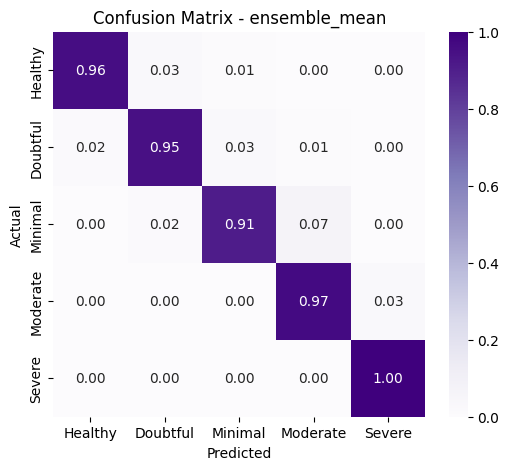

In [7]:
get_metrics(ensemble_mean, data=valid, name="ensemble_mean")
compute_confusion_matrix(
    ensemble_mean, class_names, data=valid, name="ensemble_mean"
)

35/35 [==============================] - 146s 4s/step
Accuracy Score - ensemble_acc: 0.9514388489208633
Balanced Accuracy Score - ensemble_acc: 0.9561972097420546


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       208
           1       0.96      0.95      0.95       251
           2       0.96      0.91      0.93       232
           3       0.94      0.97      0.95       329
           4       0.90      1.00      0.95        92

    accuracy                           0.95      1112
   macro avg       0.95      0.96      0.95      1112
weighted avg       0.95      0.95      0.95      1112

Confusion matrix:
[[0.96 0.03 0.01 0.   0.  ]
 [0.02 0.95 0.03 0.01 0.  ]
 [0.   0.02 0.91 0.07 0.  ]
 [0.   0.   0.   0.97 0.03]
 [0.   0.   0.   0.   1.  ]]
Classes accuracies [0.96 0.95 0.91 0.97 1.  ]
35/35 [==============================] - 145s 4s/step


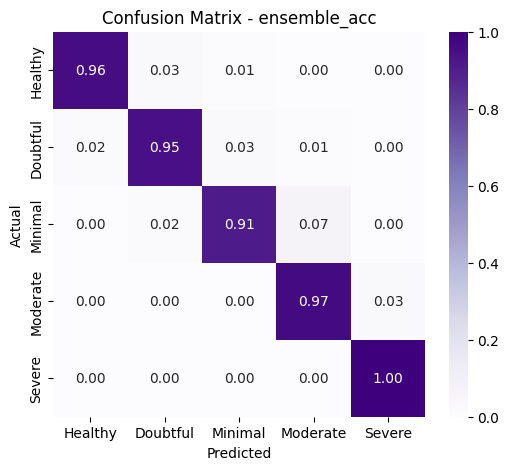

In [8]:
get_metrics(ensemble_acc, data=valid, name="ensemble_acc")
compute_confusion_matrix(
    ensemble_acc, class_names, data=valid, name="ensemble_acc"
)


35/35 [==============================] - 146s 4s/step
Accuracy Score - ensemble_f1: 0.9514388489208633
Balanced Accuracy Score - ensemble_f1: 0.9561972097420546


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       208
           1       0.96      0.95      0.95       251
           2       0.96      0.91      0.93       232
           3       0.94      0.97      0.95       329
           4       0.90      1.00      0.95        92

    accuracy                           0.95      1112
   macro avg       0.95      0.96      0.95      1112
weighted avg       0.95      0.95      0.95      1112

Confusion matrix:
[[0.96 0.03 0.01 0.   0.  ]
 [0.02 0.95 0.03 0.01 0.  ]
 [0.   0.02 0.91 0.07 0.  ]
 [0.   0.   0.   0.97 0.03]
 [0.   0.   0.   0.   1.  ]]
Classes accuracies [0.96 0.95 0.91 0.97 1.  ]
35/35 [==============================] - 145s 4s/step


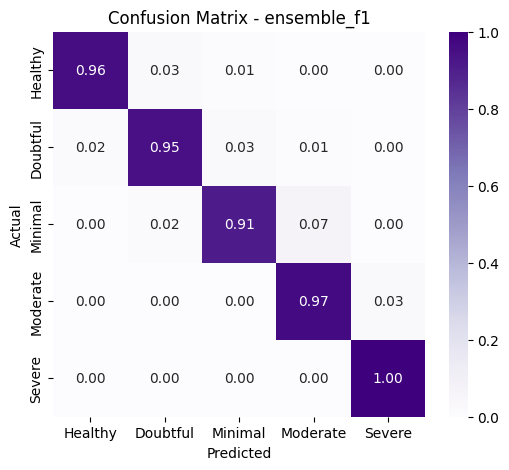

In [9]:
get_metrics(ensemble_f1, data=valid, name="ensemble_f1")
compute_confusion_matrix(
    ensemble_f1, class_names, data=valid, name="ensemble_f1"
)

55/55 [==============================] - 227s 4s/step
Accuracy Score - ensemble_f1: 0.5546605293440736
Balanced Accuracy Score - ensemble_f1: 0.650149381658131


              precision    recall  f1-score   support

           0       0.75      0.46      0.57       639
           1       0.28      0.51      0.36       296
           2       0.61      0.43      0.51       447
           3       0.58      0.87      0.69       223
           4       0.87      0.98      0.92       133

    accuracy                           0.55      1738
   macro avg       0.62      0.65      0.61      1738
weighted avg       0.62      0.55      0.56      1738

Confusion matrix:
[[0.46 0.44 0.08 0.02 0.  ]
 [0.22 0.51 0.21 0.05 0.  ]
 [0.07 0.25 0.43 0.25 0.  ]
 [0.   0.03 0.02 0.87 0.09]
 [0.   0.   0.01 0.02 0.98]]
Classes accuracies [0.46 0.51 0.43 0.87 0.98]
55/55 [==============================] - 227s 4s/step


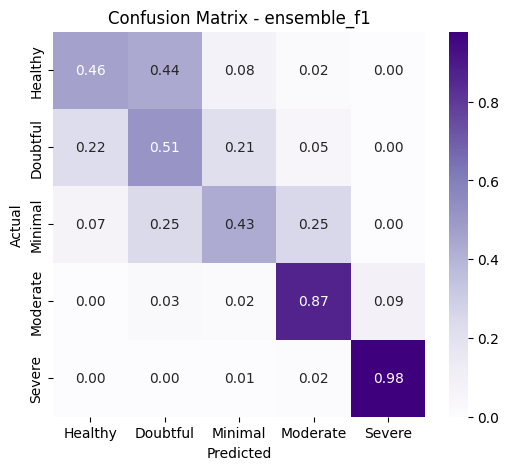

In [10]:
get_metrics(ensemble_f1, data=test, name="ensemble_f1")
compute_confusion_matrix(
    ensemble_f1, class_names, data=test, name="ensemble_f1"
)

In [11]:
y_true =test.labels
y_pred = np.argmax(ensemble_f1.predict(test), axis=1)

55/55 [==============================] - 227s 4s/step


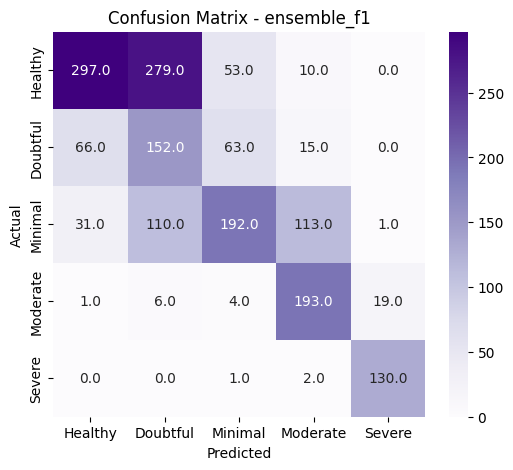

In [12]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title(f"Confusion Matrix - ensemble_f1")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show(block=False)